# Task 2 Multiclass classification Baseline

In this class, we will develop a baseline for Task 2 using the chess dataset. We will model the task as an multiclass classification task.

In [1]:
import matplotlib.pyplot as plt, numpy as np, os, torch, random, cv2, json
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torchvision import models
from torchvision.transforms import v2 as transforms
from sklearn.metrics import accuracy_score
from tqdm import tqdm

random.seed(42)

## Load dataset

**Tip**: since the images are very big, resize the dataset before loading it to save time and memory during training (use cubic interpolation to preserve image quality when downsizing the images)!

In [2]:
# Normalize images
data_aug = transforms.Compose([
    transforms.ToImage(),
    transforms.Resize((256, 256)),
    transforms.CenterCrop((224, 224)),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_in = transforms.Compose([
    transforms.ToImage(),
    transforms.Resize((256, 256)),
    transforms.CenterCrop((224, 224)),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [3]:
def chesspos2number(chesspos):
    col = ord(chesspos[0])-ord('a')
    row = int(chesspos[1])-1
    return row, col

class ChessDataset(Dataset):
    def __init__(self, root_dir, partition, transform=None):
        self.anns = json.load(open(os.path.join(root_dir, 'annotations.json')))
        self.categories = [c['name'] for c in self.anns['categories']]
        self.root = root_dir
        self.ids = []
        self.file_names = []
        for x in self.anns['images']:
            self.file_names.append(x['path'])
            self.ids.append(x['id'])
        self.file_names = np.asarray(self.file_names)
        self.ids = np.asarray(self.ids)
        self.boards = torch.zeros((len(self.file_names), 8, 8))
        for piece in self.anns['annotations']['pieces']:
            idx = np.where(self.ids == piece['image_id'])[0][0]
            row, col = chesspos2number(piece['chessboard_position'])
            self.boards[idx][row][col] = 1

        if partition == 'train':
            self.split_ids = np.asarray(self.anns['splits']['chessred2k']['train']['image_ids']).astype(int)
        elif partition == 'valid':
            self.split_ids = np.asarray(self.anns['splits']['chessred2k']['val']['image_ids']).astype(int)
        else:
            self.split_ids = np.asarray(self.anns['splits']['chessred2k']['test']['image_ids']).astype(int)

        intersect = np.isin(self.ids, self.split_ids)
        self.split_ids = np.where(intersect)[0]
        self.file_names = self.file_names[self.split_ids]
        self.boards = self.boards[self.split_ids]
        self.num_pieces = torch.sum(self.boards.view(len(self.boards), 64), axis=-1)
        self.num_pieces = F.one_hot(self.num_pieces.long()-1, 32)
        self.ids = self.ids[self.split_ids]

        self.transform = transform
        print(f"Number of {partition} images: {len(self.file_names)}")

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, i):
        image = cv2.imread(os.path.join(self.root, self.file_names[i]))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            image = self.transform(image)

        num_pieces = self.num_pieces[i]

        return image, num_pieces.float()

train_dataset = ChessDataset('', 'train', data_aug)
valid_dataset = ChessDataset('', 'valid', data_in)
test_dataset = ChessDataset('', 'test', data_in)

Number of train images: 1442
Number of valid images: 330
Number of test images: 306


In [4]:
# get cpu or gpu device for training
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# now we need to define a Dataloader, which allows us to automatically batch our inputs, do sampling and multiprocess data loading
batch_size = 1
num_workers = 0 # how many processes are used to load the data

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=False)

Using cuda device


In [5]:
import time
start = time.time()
for i, batch in enumerate(train_dataloader):
    print(f"Batch {i} loaded in {time.time() - start:.2f} seconds")
    if i >= 5:
        break
    start = time.time()

Batch 0 loaded in 0.13 seconds
Batch 1 loaded in 0.10 seconds
Batch 2 loaded in 0.09 seconds
Batch 3 loaded in 0.09 seconds
Batch 4 loaded in 0.10 seconds
Batch 5 loaded in 0.09 seconds


torch.Size([1, 224, 224, 3])
torch.Size([1, 32])
tensor(30)


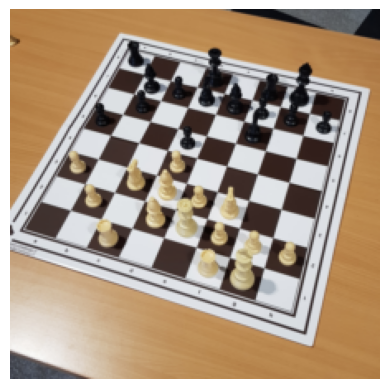

In [6]:
for batch in train_dataloader:
    # Get images of the batch and print their dimensions
    imgs = batch[0]
    imgs = imgs.permute(0, 2, 3, 1)*torch.tensor([[[0.229, 0.224, 0.225]]]) + torch.tensor([[[0.485, 0.456, 0.406]]])
    print(imgs.shape)

    # Get labels of each image in the batch and print them
    labels = batch[1]
    print(labels.shape)
    print(torch.argmax(labels[0])+1)

    # Show first image of the batch
    plt.imshow(imgs[0])
    plt.axis('off')
    plt.show()

    break

## Defining the model

We will use a pre-trained ResNet50 network.

In [7]:
# Get device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Load pretrained ResNet-50
model = models.resnet50(pretrained=True)

# Replace final classification layer (default is 1000 for ImageNet)
# You want 32 outputs — one for each possible number of pieces on the board (1 to 32)
model.fc = nn.Linear(model.fc.in_features, 32)

# Move model to device
model.to(device)


Using cuda device


c:\Users\diogo\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\diogo\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Train the model

Define function to perform one iteration

In [8]:
def train_one_batch(model, images, labels, optimizer, criterion, device):
    model.train()
    images = images.to(device)
    labels = labels.to(device)

    outputs = model(images)
    loss = criterion(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item(), outputs

Define function to train a model

In [9]:
def validate_model(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_preds = 0
    total_samples = 0

    with torch.no_grad():
        val_bar = tqdm(val_loader, desc="Validation", leave=False)
        for images, labels in val_bar:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)

            preds = torch.argmax(outputs, dim=1)
            true_labels = torch.argmax(labels, dim=1)
            correct_preds += (preds == true_labels).sum().item()
            total_samples += labels.size(0)

            avg_loss = running_loss / total_samples
            avg_acc = correct_preds / total_samples
            val_bar.set_postfix(loss=avg_loss, accuracy=avg_acc)

    val_loss = running_loss / total_samples
    val_acc = correct_preds / total_samples
    print(f"🔍Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_acc:.4f}")
    return val_loss, val_acc

def train_model(model, train_loader, val_loader, optimizer, criterion, device, num_epochs=10):
    best_val_acc = 0.0
    best_model_path = 'best_model.pth'

    train_history = {'loss': [], 'accuracy': []}
    val_history = {'loss': [], 'accuracy': []}

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_preds = 0
        total_samples = 0

        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} Training")

        for images, labels in train_bar:
            loss, outputs = train_one_batch(model, images, labels, optimizer, criterion, device)
            running_loss += loss * images.size(0)

            preds = torch.argmax(outputs, dim=1)
            true_labels = torch.argmax(labels, dim=1).to(device)
            correct_preds += (preds == true_labels).sum().item()
            total_samples += labels.size(0)

            avg_loss = running_loss / total_samples
            avg_acc = correct_preds / total_samples
            train_bar.set_postfix(loss=avg_loss, accuracy=avg_acc)

        train_history['loss'].append(avg_loss)
        train_history['accuracy'].append(avg_acc)
        print(f"✔️Epoch {epoch+1} Train Loss: {avg_loss:.4f} | Train Accuracy: {avg_acc:.4f}")

        if val_loader:
            val_loss, val_acc = validate_model(model, val_loader, criterion, device)
            val_history['loss'].append(val_loss)
            val_history['accuracy'].append(val_acc)

            # Save best model
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                torch.save(model.state_dict(), best_model_path)
                print(f"Best model saved with accuracy: {best_val_acc:.4f}")

    return train_history, val_history

Define loss, optimizer and train the model

In [10]:
import torch.nn as nn
import torch.optim as optim

# Define loss function
loss_fn = nn.CrossEntropyLoss()

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Number of epochs
num_epochs = 50

# Train the model
train_history, val_history = train_model(model, train_dataloader, valid_dataloader, optimizer, loss_fn, device, num_epochs)


Epoch 1/50 Training: 100%|██████████| 1442/1442 [03:59<00:00,  6.01it/s, accuracy=0.0964, loss=3.16]


✔️Epoch 1 Train Loss: 3.1593 | Train Accuracy: 0.0964


🔍Validation Loss: 3.5208 | Validation Accuracy: 0.1121
Best model saved with accuracy: 0.1121


Epoch 2/50 Training: 100%|██████████| 1442/1442 [03:52<00:00,  6.19it/s, accuracy=0.0992, loss=3.11]


✔️Epoch 2 Train Loss: 3.1120 | Train Accuracy: 0.0992


🔍Validation Loss: 5.2460 | Validation Accuracy: 0.1121


Epoch 3/50 Training: 100%|██████████| 1442/1442 [03:43<00:00,  6.46it/s, accuracy=0.102, loss=3.08] 


✔️Epoch 3 Train Loss: 3.0830 | Train Accuracy: 0.1019


🔍Validation Loss: 6.2201 | Validation Accuracy: 0.0879


Epoch 4/50 Training: 100%|██████████| 1442/1442 [03:44<00:00,  6.42it/s, accuracy=0.123, loss=3.01]


✔️Epoch 4 Train Loss: 3.0051 | Train Accuracy: 0.1234


🔍Validation Loss: 4.1345 | Validation Accuracy: 0.1212
Best model saved with accuracy: 0.1212


Epoch 5/50 Training: 100%|██████████| 1442/1442 [03:52<00:00,  6.21it/s, accuracy=0.16, loss=2.87] 


✔️Epoch 5 Train Loss: 2.8690 | Train Accuracy: 0.1595


🔍Validation Loss: 3.9030 | Validation Accuracy: 0.0758


Epoch 6/50 Training: 100%|██████████| 1442/1442 [03:52<00:00,  6.20it/s, accuracy=0.169, loss=2.7] 


✔️Epoch 6 Train Loss: 2.6998 | Train Accuracy: 0.1692


🔍Validation Loss: 4.3548 | Validation Accuracy: 0.0485


Epoch 7/50 Training: 100%|██████████| 1442/1442 [03:51<00:00,  6.22it/s, accuracy=0.194, loss=2.55]


✔️Epoch 7 Train Loss: 2.5540 | Train Accuracy: 0.1942


🔍Validation Loss: 4.1629 | Validation Accuracy: 0.0576


Epoch 8/50 Training: 100%|██████████| 1442/1442 [03:52<00:00,  6.19it/s, accuracy=0.215, loss=2.4] 


✔️Epoch 8 Train Loss: 2.3981 | Train Accuracy: 0.2150


🔍Validation Loss: 4.0794 | Validation Accuracy: 0.0061


Epoch 9/50 Training: 100%|██████████| 1442/1442 [03:52<00:00,  6.21it/s, accuracy=0.235, loss=2.27]


✔️Epoch 9 Train Loss: 2.2710 | Train Accuracy: 0.2351


🔍Validation Loss: 4.9241 | Validation Accuracy: 0.0242


Epoch 10/50 Training: 100%|██████████| 1442/1442 [03:52<00:00,  6.21it/s, accuracy=0.277, loss=2.16]


✔️Epoch 10 Train Loss: 2.1644 | Train Accuracy: 0.2767


🔍Validation Loss: 4.7913 | Validation Accuracy: 0.0182


Epoch 11/50 Training: 100%|██████████| 1442/1442 [03:53<00:00,  6.19it/s, accuracy=0.25, loss=2.11] 


✔️Epoch 11 Train Loss: 2.1144 | Train Accuracy: 0.2503


🔍Validation Loss: 4.0455 | Validation Accuracy: 0.0152


Epoch 12/50 Training: 100%|██████████| 1442/1442 [03:51<00:00,  6.24it/s, accuracy=0.3, loss=2.03]  


✔️Epoch 12 Train Loss: 2.0318 | Train Accuracy: 0.3003


🔍Validation Loss: 4.5459 | Validation Accuracy: 0.0485


Epoch 13/50 Training: 100%|██████████| 1442/1442 [03:46<00:00,  6.37it/s, accuracy=0.324, loss=1.95]


✔️Epoch 13 Train Loss: 1.9490 | Train Accuracy: 0.3239


🔍Validation Loss: 4.1501 | Validation Accuracy: 0.0394


Epoch 14/50 Training: 100%|██████████| 1442/1442 [03:51<00:00,  6.24it/s, accuracy=0.335, loss=1.88]


✔️Epoch 14 Train Loss: 1.8762 | Train Accuracy: 0.3350


🔍Validation Loss: 4.1635 | Validation Accuracy: 0.0545


Epoch 15/50 Training: 100%|██████████| 1442/1442 [03:46<00:00,  6.37it/s, accuracy=0.356, loss=1.78]


✔️Epoch 15 Train Loss: 1.7848 | Train Accuracy: 0.3558


🔍Validation Loss: 4.1986 | Validation Accuracy: 0.0242


Epoch 16/50 Training: 100%|██████████| 1442/1442 [03:45<00:00,  6.38it/s, accuracy=0.368, loss=1.73]


✔️Epoch 16 Train Loss: 1.7304 | Train Accuracy: 0.3675


🔍Validation Loss: 4.5157 | Validation Accuracy: 0.0030


Epoch 17/50 Training: 100%|██████████| 1442/1442 [03:45<00:00,  6.40it/s, accuracy=0.389, loss=1.73]


✔️Epoch 17 Train Loss: 1.7279 | Train Accuracy: 0.3890


🔍Validation Loss: 4.3541 | Validation Accuracy: 0.0333


Epoch 18/50 Training: 100%|██████████| 1442/1442 [03:46<00:00,  6.37it/s, accuracy=0.399, loss=1.61]


✔️Epoch 18 Train Loss: 1.6126 | Train Accuracy: 0.3994


🔍Validation Loss: 4.4720 | Validation Accuracy: 0.0061


Epoch 19/50 Training: 100%|██████████| 1442/1442 [03:45<00:00,  6.39it/s, accuracy=0.417, loss=1.59]


✔️Epoch 19 Train Loss: 1.5939 | Train Accuracy: 0.4168


🔍Validation Loss: 4.9635 | Validation Accuracy: 0.0212


Epoch 20/50 Training: 100%|██████████| 1442/1442 [03:44<00:00,  6.42it/s, accuracy=0.442, loss=1.52]


✔️Epoch 20 Train Loss: 1.5234 | Train Accuracy: 0.4424


🔍Validation Loss: 5.1634 | Validation Accuracy: 0.0455


Epoch 21/50 Training: 100%|██████████| 1442/1442 [03:47<00:00,  6.35it/s, accuracy=0.472, loss=1.47]


✔️Epoch 21 Train Loss: 1.4682 | Train Accuracy: 0.4716


🔍Validation Loss: 4.1655 | Validation Accuracy: 0.0333


Epoch 22/50 Training: 100%|██████████| 1442/1442 [03:44<00:00,  6.41it/s, accuracy=0.469, loss=1.43]


✔️Epoch 22 Train Loss: 1.4308 | Train Accuracy: 0.4695


🔍Validation Loss: 5.0141 | Validation Accuracy: 0.0424


Epoch 23/50 Training: 100%|██████████| 1442/1442 [03:44<00:00,  6.42it/s, accuracy=0.485, loss=1.38]


✔️Epoch 23 Train Loss: 1.3780 | Train Accuracy: 0.4847


🔍Validation Loss: 6.0206 | Validation Accuracy: 0.0152


Epoch 24/50 Training: 100%|██████████| 1442/1442 [03:47<00:00,  6.35it/s, accuracy=0.501, loss=1.33]


✔️Epoch 24 Train Loss: 1.3342 | Train Accuracy: 0.5014


🔍Validation Loss: 4.9383 | Validation Accuracy: 0.0152


Epoch 25/50 Training: 100%|██████████| 1442/1442 [03:52<00:00,  6.21it/s, accuracy=0.51, loss=1.29] 


✔️Epoch 25 Train Loss: 1.2939 | Train Accuracy: 0.5104


🔍Validation Loss: 4.2407 | Validation Accuracy: 0.0152


Epoch 26/50 Training: 100%|██████████| 1442/1442 [03:45<00:00,  6.39it/s, accuracy=0.522, loss=1.24]


✔️Epoch 26 Train Loss: 1.2423 | Train Accuracy: 0.5222


🔍Validation Loss: 4.6402 | Validation Accuracy: 0.0212


Epoch 27/50 Training: 100%|██████████| 1442/1442 [03:44<00:00,  6.41it/s, accuracy=0.546, loss=1.19]


✔️Epoch 27 Train Loss: 1.1936 | Train Accuracy: 0.5458


🔍Validation Loss: 4.7366 | Validation Accuracy: 0.0424


Epoch 28/50 Training: 100%|██████████| 1442/1442 [03:50<00:00,  6.27it/s, accuracy=0.531, loss=1.19]


✔️Epoch 28 Train Loss: 1.1943 | Train Accuracy: 0.5305


🔍Validation Loss: 4.6114 | Validation Accuracy: 0.0303


Epoch 29/50 Training: 100%|██████████| 1442/1442 [03:46<00:00,  6.37it/s, accuracy=0.559, loss=1.14]


✔️Epoch 29 Train Loss: 1.1388 | Train Accuracy: 0.5589


🔍Validation Loss: 5.2628 | Validation Accuracy: 0.0455


Epoch 30/50 Training: 100%|██████████| 1442/1442 [03:45<00:00,  6.39it/s, accuracy=0.576, loss=1.14]


✔️Epoch 30 Train Loss: 1.1409 | Train Accuracy: 0.5756


🔍Validation Loss: 5.2994 | Validation Accuracy: 0.0576


Epoch 31/50 Training: 100%|██████████| 1442/1442 [03:46<00:00,  6.37it/s, accuracy=0.589, loss=1.05]


✔️Epoch 31 Train Loss: 1.0535 | Train Accuracy: 0.5895


🔍Validation Loss: 4.1534 | Validation Accuracy: 0.0273


Epoch 32/50 Training: 100%|██████████| 1442/1442 [03:45<00:00,  6.38it/s, accuracy=0.608, loss=1.02] 


✔️Epoch 32 Train Loss: 1.0197 | Train Accuracy: 0.6082


🔍Validation Loss: 5.0990 | Validation Accuracy: 0.0121


Epoch 33/50 Training: 100%|██████████| 1442/1442 [03:45<00:00,  6.39it/s, accuracy=0.627, loss=0.976]


✔️Epoch 33 Train Loss: 0.9761 | Train Accuracy: 0.6269


🔍Validation Loss: 3.7572 | Validation Accuracy: 0.0515


Epoch 34/50 Training: 100%|██████████| 1442/1442 [03:46<00:00,  6.38it/s, accuracy=0.626, loss=0.965]


✔️Epoch 34 Train Loss: 0.9647 | Train Accuracy: 0.6255


🔍Validation Loss: 5.1427 | Validation Accuracy: 0.0152


Epoch 35/50 Training: 100%|██████████| 1442/1442 [03:46<00:00,  6.37it/s, accuracy=0.672, loss=0.871]


✔️Epoch 35 Train Loss: 0.8707 | Train Accuracy: 0.6720


🔍Validation Loss: 3.8587 | Validation Accuracy: 0.0758


Epoch 36/50 Training: 100%|██████████| 1442/1442 [03:46<00:00,  6.37it/s, accuracy=0.653, loss=0.926]


✔️Epoch 36 Train Loss: 0.9258 | Train Accuracy: 0.6526


🔍Validation Loss: 5.9589 | Validation Accuracy: 0.0182


Epoch 37/50 Training: 100%|██████████| 1442/1442 [03:45<00:00,  6.39it/s, accuracy=0.699, loss=0.813]


✔️Epoch 37 Train Loss: 0.8134 | Train Accuracy: 0.6990


🔍Validation Loss: 4.8229 | Validation Accuracy: 0.0121


Epoch 38/50 Training: 100%|██████████| 1442/1442 [03:50<00:00,  6.26it/s, accuracy=0.716, loss=0.79] 


✔️Epoch 38 Train Loss: 0.7899 | Train Accuracy: 0.7157


🔍Validation Loss: 3.9818 | Validation Accuracy: 0.0455


Epoch 39/50 Training: 100%|██████████| 1442/1442 [03:46<00:00,  6.36it/s, accuracy=0.73, loss=0.76]  


✔️Epoch 39 Train Loss: 0.7603 | Train Accuracy: 0.7295


🔍Validation Loss: 5.2601 | Validation Accuracy: 0.0394


Epoch 40/50 Training: 100%|██████████| 1442/1442 [03:46<00:00,  6.37it/s, accuracy=0.719, loss=0.744]


✔️Epoch 40 Train Loss: 0.7437 | Train Accuracy: 0.7191


🔍Validation Loss: 4.8557 | Validation Accuracy: 0.0394


Epoch 41/50 Training: 100%|██████████| 1442/1442 [03:51<00:00,  6.23it/s, accuracy=0.754, loss=0.68] 


✔️Epoch 41 Train Loss: 0.6802 | Train Accuracy: 0.7538


🔍Validation Loss: 4.6515 | Validation Accuracy: 0.0394


Epoch 42/50 Training: 100%|██████████| 1442/1442 [03:48<00:00,  6.30it/s, accuracy=0.764, loss=0.662]


✔️Epoch 42 Train Loss: 0.6622 | Train Accuracy: 0.7635


🔍Validation Loss: 5.2402 | Validation Accuracy: 0.0333


Epoch 43/50 Training: 100%|██████████| 1442/1442 [03:46<00:00,  6.36it/s, accuracy=0.788, loss=0.578]


✔️Epoch 43 Train Loss: 0.5783 | Train Accuracy: 0.7878


🔍Validation Loss: 4.6461 | Validation Accuracy: 0.0212


Epoch 44/50 Training: 100%|██████████| 1442/1442 [03:46<00:00,  6.37it/s, accuracy=0.793, loss=0.601]


✔️Epoch 44 Train Loss: 0.6013 | Train Accuracy: 0.7926


🔍Validation Loss: 4.2581 | Validation Accuracy: 0.0879


Epoch 45/50 Training: 100%|██████████| 1442/1442 [03:45<00:00,  6.40it/s, accuracy=0.785, loss=0.608]


✔️Epoch 45 Train Loss: 0.6081 | Train Accuracy: 0.7850


🔍Validation Loss: 5.2671 | Validation Accuracy: 0.0212


Epoch 46/50 Training: 100%|██████████| 1442/1442 [03:45<00:00,  6.39it/s, accuracy=0.827, loss=0.495]


✔️Epoch 46 Train Loss: 0.4951 | Train Accuracy: 0.8266


🔍Validation Loss: 4.5442 | Validation Accuracy: 0.0818


Epoch 47/50 Training: 100%|██████████| 1442/1442 [03:46<00:00,  6.37it/s, accuracy=0.832, loss=0.503]


✔️Epoch 47 Train Loss: 0.5026 | Train Accuracy: 0.8322


🔍Validation Loss: 4.2707 | Validation Accuracy: 0.0970


Epoch 48/50 Training: 100%|██████████| 1442/1442 [03:45<00:00,  6.40it/s, accuracy=0.827, loss=0.495]


✔️Epoch 48 Train Loss: 0.4951 | Train Accuracy: 0.8266


🔍Validation Loss: 4.4241 | Validation Accuracy: 0.0606


Epoch 49/50 Training: 100%|██████████| 1442/1442 [03:45<00:00,  6.40it/s, accuracy=0.863, loss=0.393]


✔️Epoch 49 Train Loss: 0.3935 | Train Accuracy: 0.8634


🔍Validation Loss: 5.3667 | Validation Accuracy: 0.0939


Epoch 50/50 Training: 100%|██████████| 1442/1442 [03:45<00:00,  6.40it/s, accuracy=0.883, loss=0.363]


✔️Epoch 50 Train Loss: 0.3626 | Train Accuracy: 0.8835


🔍Validation Loss: 5.9105 | Validation Accuracy: 0.0758


## Analyse training evolution

Plot loss and accuracy throughout training on train and validation data

In [11]:
def plot_training_history(train_history, val_history):
    plt.figure(figsize=(12,5))

    plt.subplot(1, 2, 1)
    plt.plot(train_history['loss'], label='Train Loss')
    plt.plot(val_history['loss'], label='Val Loss')
    plt.title('Loss over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_history['accuracy'], label='Train Accuracy')
    plt.plot(val_history['accuracy'], label='Val Accuracy')
    plt.title('Accuracy over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

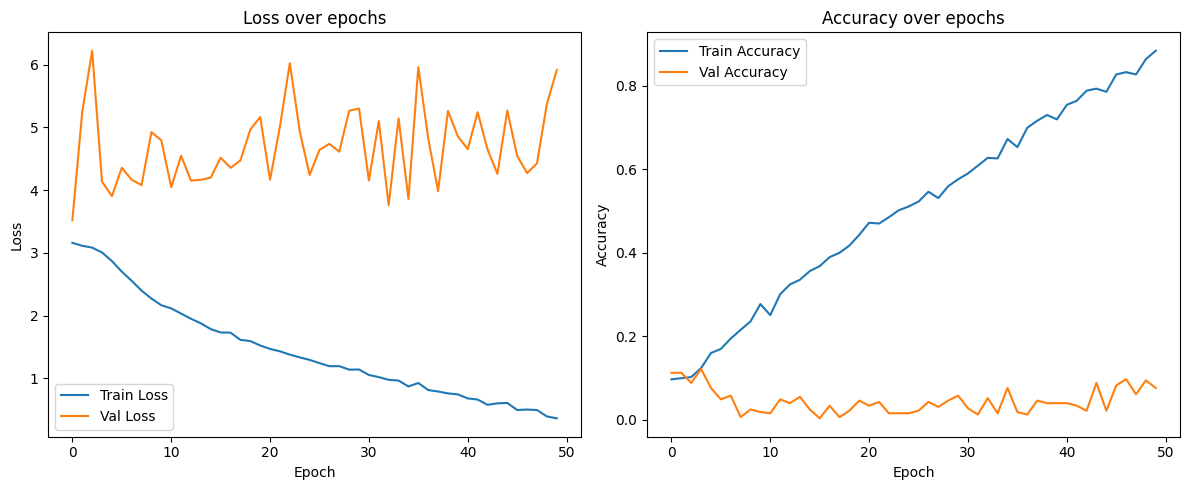

In [12]:
plot_training_history(train_history, val_history)

## Test the model

Evaluate the model in the test set

In [13]:
def test_model(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_preds = 0
    total_samples = 0

    test_bar = tqdm(test_loader, desc="Testing")

    with torch.no_grad():
        for images, labels in test_bar:
            images = images.to(device)
            labels = torch.argmax(labels, dim=1).to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct_preds += (preds == labels).sum().item()
            total_samples += labels.size(0)

            avg_loss = running_loss / total_samples
            avg_acc = correct_preds / total_samples
            test_bar.set_postfix(loss=avg_loss, acc=avg_acc)

    test_loss = running_loss / total_samples
    test_acc = correct_preds / total_samples

    print(f"\nTest Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")


In [14]:
def load_model(model, model_path, device):
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    print(f"Loaded model from {model_path}")

In [15]:
def test_model(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_preds = 0
    total_samples = 0

    test_bar = tqdm(test_loader, desc="Testing")

    with torch.no_grad():
        for images, labels in test_bar:
            images = images.to(device)
            labels = torch.argmax(labels, dim=1).to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct_preds += (preds == labels).sum().item()
            total_samples += labels.size(0)

            avg_loss = running_loss / total_samples
            avg_acc = correct_preds / total_samples
            test_bar.set_postfix(loss=avg_loss, accuracy=avg_acc)

    test_loss = running_loss / total_samples
    test_acc = correct_preds / total_samples

    print(f"\nTest Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")
    return test_loss, test_acc

# Exemplo de uso:

best_model_path = 'best_model.pth'  # caminho para o melhor modelo guardado

# Carrega o modelo antes do teste
load_model(model, best_model_path, device)

# Avalia no conjunto de teste
test_loss, test_acc = test_model(model, test_dataloader, loss_fn, device)

Loaded model from best_model.pth


Testing: 100%|██████████| 306/306 [00:43<00:00,  6.99it/s, accuracy=0.193, loss=3.26]


Test Loss: 3.2588 | Test Accuracy: 0.1928


## Challenge

In transfer learning, we often replace the head of the model (fully-connected layers responsible for classification) to fit the task. However, these new layers are not pre-trained and thus they contain an error that is backpropagated through the pre-trained part of the network during training. We can avoid this through a training strategy that is divided into two steps:
* Freeze the pre-trained layers of the network so that their parameters are no longer updated during training and train only the head of the model
* Unfreeze these layers and train the network as a whole.

Implement this strategy and see the results!

## For Group Project - Task 2: Adapt multiclass classification network to regression!

Now that you have a multiclass baseline, adapt the network for the regression problem, considering the following aspects:
* How many neurons should the last layer of a regression network have?
* What should be the final activation function for a regression network?
* What loss functions can be used to train a regression network?